# Load Data

In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepaths = glob.glob("../data/tidy/acetaminophen/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
apap_daily = df.resample("D").count()[["EVENT_ID"]]
apap_daily.columns = ["Doses"]

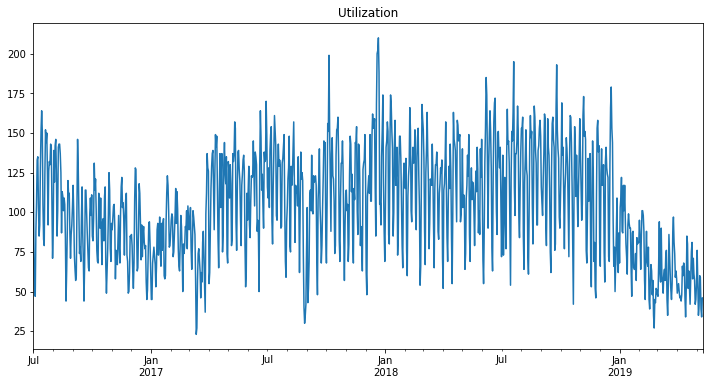

In [4]:
ax = apap_daily.plot(legend=False, figsize=(12, 6), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

# ACF

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

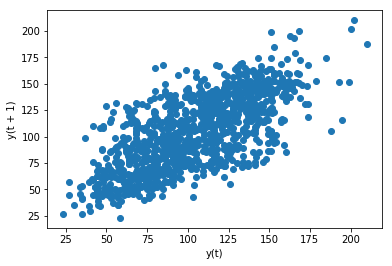

In [6]:
lag_plot(apap_daily["Doses"]);

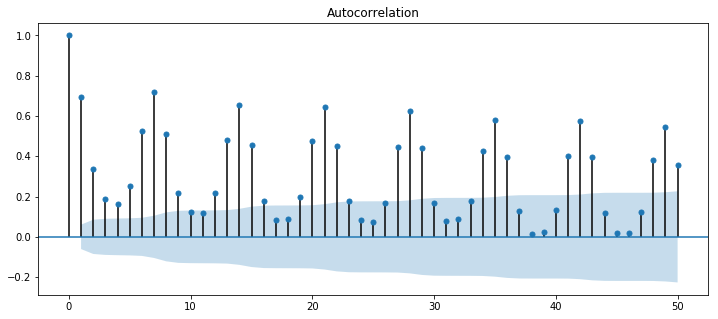

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

plot_acf(apap_daily["Doses"], lags=50, ax=ax);
#plot_acf(apap_daily);

In [8]:
# data is not stationary; p-value > 0.05
adfuller(apap_daily["Doses"].dropna(), autolag='AIC')[1]

0.2978121675515909

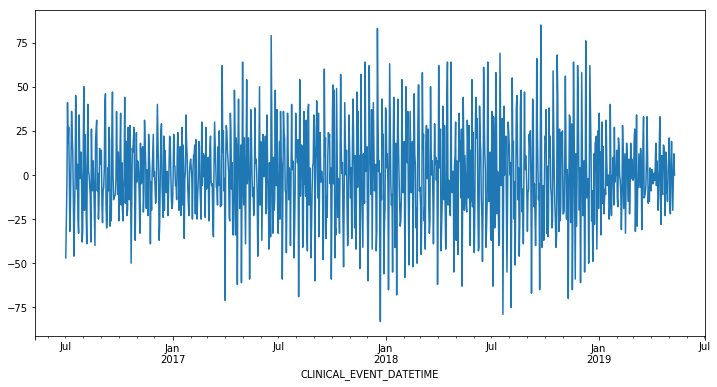

In [9]:
# difference the data to make it stationary
df_diff = apap_daily.copy()
df_diff["Doses"] = diff(apap_daily["Doses"], k_diff=1)
df_diff["Doses"].plot(figsize=(12, 6))

In [10]:
adfuller(df_diff["Doses"].dropna(), autolag='AIC')[1]

3.674029188920869e-19

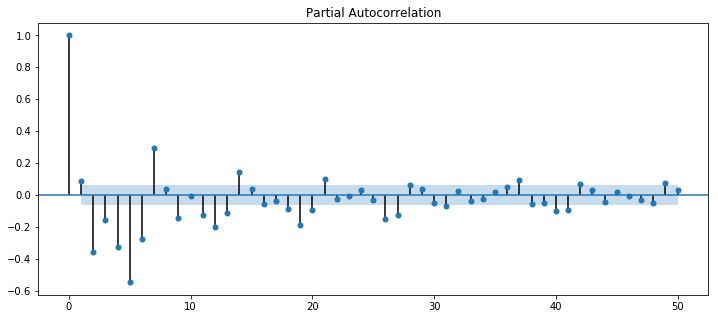

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Doses"].dropna(), lags=50, ax=ax);

In [7]:
from sklearn.model_selection import GridSearchCV

# RNN

In [12]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

Using TensorFlow backend.


In [13]:
n_inputs = 60
n_features = 1
n_valid = 7
n_pred = 30
batch_size = 32

In [14]:
#df = apap_daily
df = df_diff.dropna()
l = len(df) - n_pred
train_set = df.iloc[:l]
train = df.iloc[:l - n_valid]
valid = df.iloc[l - n_inputs - n_valid:l]
test_set = df.iloc[l:]

In [15]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_valid = scaler.transform(valid)
scaled_train_set = scaler.transform(train_set)
scaled_test_set = scaler.transform(test_set)

In [16]:
gen_train = TimeseriesGenerator(scaled_train, scaled_train, length=n_inputs, batch_size=batch_size)

In [17]:
gen_valid = TimeseriesGenerator(scaled_valid, scaled_valid, length=n_inputs, batch_size=batch_size)

In [18]:
#for i in range(len(gen_valid)):
#    x, y = gen_valid[i]
#    print('%s => %s' % (x, y))

In [19]:
# int(len(apap_daily) / (2 * (n_inputs + n_features)))
#n_nodes = int(2/3 * (n_inputs + n_features))
n_nodes = 200

In [20]:
model = Sequential()
#model.add(LSTM(n_nodes, activation="relu", input_shape=(n_inputs, n_features), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(n_nodes, activation="relu", input_shape=(n_inputs, n_features), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit_generator(gen_train, epochs=500, validation_data=gen_valid)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
30/30 [==============================] - 11s 382ms/step - loss: 0.1031 - val_loss: 0.0035
Epoch 2/500
30/30 [==============================] - 6s 211ms/step - loss: 0.0287 - val_loss: 0.0032
Epoch 3/500
30/30 [==============================] - 7s 226ms/step - loss: 0.0293 - val_loss: 0.0026
Epoch 4/500
30/30 [==============================] - 10s 319ms/step - loss: 0.0278 - val_loss: 0.0023
Epoch 5/500
30/30 [==============================] - 8s 273ms/step - loss: 0.0280 - val_loss: 0.0024
Epoch 6/500
30/30 [==============================] - 10s 321ms/step - loss: 0.0280 - val_loss: 0.0033
Epoch 7/500
30/30 [==============================] - 8s 268ms/step - loss: 0.0279 - val_loss: 0.0037
Epoch 8/500
30/30 [==============================] - 6s 211ms/step - loss: 0.0277 - val_loss: 0.0022
Epoch 9/500
30/30 [==============================] - 7s 244ms/step - loss: 0.0270 - val_loss: 0.0024
Epoch 10/500
30/30 [====================

Epoch 158/500
30/30 [==============================] - 8s 271ms/step - loss: 0.0104 - val_loss: 0.0039
Epoch 159/500
30/30 [==============================] - 7s 243ms/step - loss: 0.0102 - val_loss: 0.0036
Epoch 160/500
30/30 [==============================] - 7s 230ms/step - loss: 0.0100 - val_loss: 0.0041
Epoch 161/500
30/30 [==============================] - 8s 277ms/step - loss: 0.0104 - val_loss: 0.0033
Epoch 162/500
30/30 [==============================] - 8s 273ms/step - loss: 0.0103 - val_loss: 0.0028
Epoch 163/500
30/30 [==============================] - 7s 241ms/step - loss: 0.0100 - val_loss: 0.0036
Epoch 164/500
30/30 [==============================] - 7s 236ms/step - loss: 0.0098 - val_loss: 0.0037
Epoch 165/500
30/30 [==============================] - 7s 232ms/step - loss: 0.0102 - val_loss: 0.0031
Epoch 166/500
30/30 [==============================] - 8s 252ms/step - loss: 0.0101 - val_loss: 0.0033
Epoch 167/500
30/30 [==============================] - 7s 231ms/step - lo

30/30 [==============================] - 6s 198ms/step - loss: 0.0094 - val_loss: 0.0028
Epoch 317/500
30/30 [==============================] - 6s 202ms/step - loss: 0.0091 - val_loss: 0.0032
Epoch 318/500
30/30 [==============================] - 6s 191ms/step - loss: 0.0094 - val_loss: 0.0028
Epoch 319/500
30/30 [==============================] - 5s 170ms/step - loss: 0.0096 - val_loss: 0.0036
Epoch 320/500
30/30 [==============================] - 5s 177ms/step - loss: 0.0089 - val_loss: 0.0041
Epoch 321/500
30/30 [==============================] - 6s 185ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 322/500
30/30 [==============================] - 5s 174ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 323/500
30/30 [==============================] - 5s 179ms/step - loss: 0.0097 - val_loss: 0.0040
Epoch 324/500
30/30 [==============================] - 6s 188ms/step - loss: 0.0097 - val_loss: 0.0037
Epoch 325/500
30/30 [==============================] - 5s 178ms/step - loss: 0.0095 - v

30/30 [==============================] - 5s 182ms/step - loss: 0.0088 - val_loss: 0.0042
Epoch 475/500
30/30 [==============================] - 5s 175ms/step - loss: 0.0088 - val_loss: 0.0036
Epoch 476/500
30/30 [==============================] - 5s 174ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 477/500
30/30 [==============================] - 5s 174ms/step - loss: 0.0093 - val_loss: 0.0031
Epoch 478/500
30/30 [==============================] - 5s 182ms/step - loss: 0.0089 - val_loss: 0.0036
Epoch 479/500
30/30 [==============================] - 5s 173ms/step - loss: 0.0088 - val_loss: 0.0043
Epoch 480/500
30/30 [==============================] - 5s 162ms/step - loss: 0.0089 - val_loss: 0.0032
Epoch 481/500
30/30 [==============================] - 5s 160ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 482/500
30/30 [==============================] - 5s 166ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 483/500
30/30 [==============================] - 5s 164ms/step - loss: 0.0091 - v

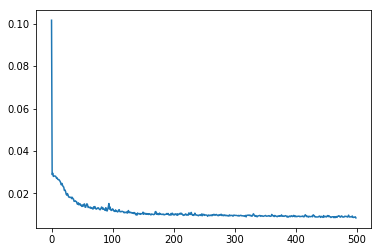

In [23]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [24]:
test_preds = []
first_batch = scaled_train_set[-n_inputs:]
current_batch = first_batch.reshape((1, n_inputs, n_features))

for i in range(len(test_set)):
    current_pred = model.predict(current_batch)[0]
    test_preds.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [25]:
true_preds = scaler.inverse_transform(test_preds)
test_set["Predictions"] = true_preds

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


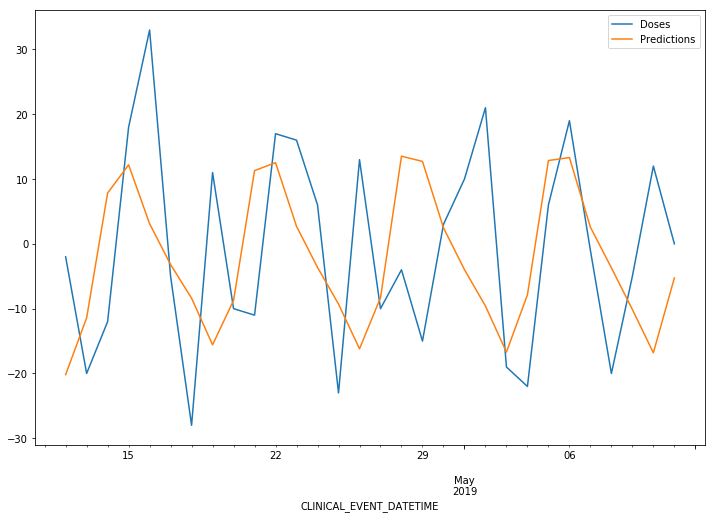

In [26]:
test_set.plot(figsize=(12, 8));

In [27]:
mse_rnn = mean_squared_error(test_set["Doses"], test_set["Predictions"])
rmse_rnn = rmse(test_set["Doses"],  test_set["Predictions"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN: 276.8374148
RMSE RNN: 16.63843186


# Forecast

In [28]:
n_fcast = 60
new_preds = []
first_batch = scaler.transform(df[-n_inputs:])
current_batch = first_batch.reshape((1, n_inputs, n_features))

for i in range(n_fcast):
    current_pred = model.predict(current_batch)[0]
    new_preds.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [29]:
unscaled_preds = scaler.inverse_transform(new_preds)
undiff_preds = apap_daily["Doses"].iloc[-1] + unscaled_preds.cumsum()
df_preds = pd.DataFrame(undiff_preds, columns=["Predictions"])
idx = pd.date_range(apap_daily.index[-1] + 1, periods = n_fcast, freq="D")
df_preds.index = idx

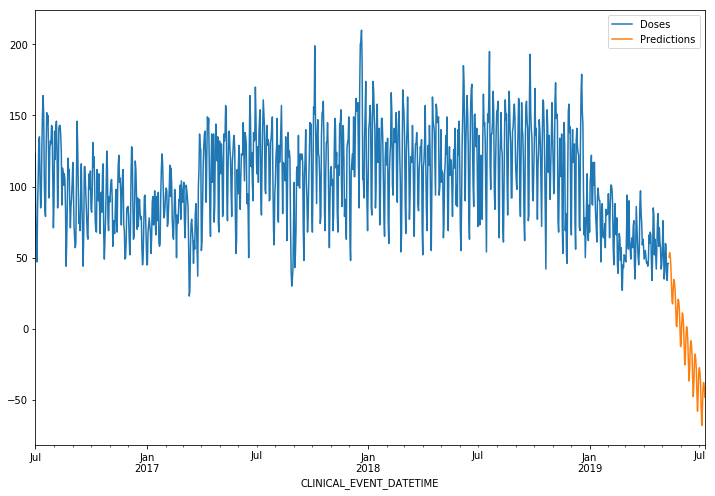

In [30]:
ax = apap_daily["Doses"].plot(figsize=(12, 8), legend=True)
df_preds["Predictions"].plot(legend=True);
ax.autoscale(axis='x',tight=True)

In [31]:
model.save("acetaminophen_rnn_1-layer.h5")

In [32]:
df_preds.columns = ["Doses"]
apap_monthly = [apap_daily, df_preds]
apap_monthly = pd.concat(apap_monthly)
apap_monthly = apap_monthly.loc[:"2020-04-30"].resample("MS").sum()

In [90]:
#apap_monthly

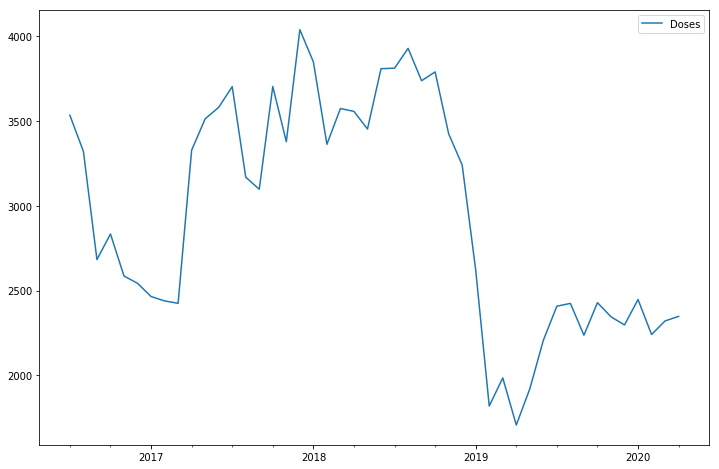

In [26]:
apap_monthly.plot(figsize=(12, 8))